In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression
import heapq
from scipy.stats import pearsonr
import xgboost as xgb
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

# 加载数据文件
dataFileName = "D:\\Documents\\Jupyter Notebook\\data\\cude_oil_prediction\\原始数据.xlsx"
data = pd.read_excel(dataFileName, sheet_name="END")

data_names = ["CPI", "NHG", "CFNAI", "UER", "FPO", "ICO", "ECO", "USR", "NYF", "CUM", "UMS", "CUO", "NG", "DJI", "SP500",
              "DXY", "GOLD", "SV", "HIS", "US10B", "BP", "EC", "UC", "WTI", "Brent"]
data_values = {}
for i in range(len(data_names)):
    data_values[data_names[i]] = data[data_names[i]].values
print(data_names[-1])
target_feature = data_names[-1]

Brent


In [2]:
# 得到想要继续特征筛选的X，y数组
def selectArray():
    X = np.zeros((len(data[target_feature].values), len(data_names) - 1))
    y = np.zeros_like(data[target_feature].values)
    for i in range(len(data_names) - 1):
        X[:, i] = data_values[data_names[i]]
    y = data_values[target_feature]
    return X[:int(len(X) * 0.7)], y[:int(len(X) * 0.7)]
# 根据训练集选择特征

feature_X, feature_y = selectArray()
scaler = StandardScaler()
feature_X = scaler.fit_transform(feature_X)
feature_y = scaler.fit_transform(feature_y.reshape(-1, 1))

def getGreyRelation(X, y, k):
    global_min = np.min(np.abs(y - X))
    global_max = np.max(np.abs(y - X))
    rho = 0.5
    res = (global_min + rho * global_max) / (np.abs(y - X) + rho * global_max)
    res = np.sum(res, axis=0) / len(res)
    return np.sort(np.array(heapq.nlargest(k, enumerate(res), key=lambda x: x[1]))[:, 0].astype(int))

def getPearsonRelation(X, y, k):
    pearson_index = np.array([])
    for i in range(len(X[0])):
#         print(X[:, i].shape, y.shape)
        pearson_index = np.append(pearson_index, pearsonr(X[:, i], y.reshape(-1))[0])
    return np.sort(np.array(heapq.nlargest(k, enumerate(pearson_index), key=lambda x: x[1]))[:, 0].astype(int))

def getMiRelation(X, y, k):
    selector = SelectKBest(mutual_info_regression, k=k).fit(X, y.ravel())
    selected_mi_features = selector.get_support(indices=True)
    return selected_mi_features

def getXGboostRelation(X, y, k):
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
    xgb_model.fit(X, y)
    importance = xgb_model.feature_importances_
    return np.sort(np.array(heapq.nlargest(k, enumerate(importance), key=lambda x: x[1]))[:, 0].astype(int))

k = 6
selected_grey_features = getGreyRelation(feature_X, feature_y, k)

selected_mi_features = getMiRelation(feature_X, feature_y, k)

selected_pearson_features = getPearsonRelation(feature_X, feature_y, k)

selected_xgboost_features = getXGboostRelation(feature_X, feature_y, k)

print(np.array(data_names)[selected_grey_features])
print(np.array(data_names)[selected_mi_features])
print(np.array(data_names)[selected_pearson_features])
print(np.array(data_names)[selected_xgboost_features])

selected_features = set(selected_grey_features) & set(selected_mi_features) \
                  & set(selected_pearson_features) & set(selected_xgboost_features)
print(selected_features)
selected_features = set()
print(np.array(data_names)[list(selected_features)])
selected_features.add(-1)
print(np.array(data_names)[list(selected_features)])

['CPI' 'NHG' 'NYF' 'GOLD' 'SV' 'WTI']
['CPI' 'NHG' 'NYF' 'GOLD' 'UC' 'WTI']
['CPI' 'NHG' 'NYF' 'GOLD' 'SV' 'WTI']
['CPI' 'NHG' 'NYF' 'DXY' 'SV' 'WTI']
{0, 1, 8, 23}
[]
['Brent']


In [3]:
# 拿到窗口划分之后的数据集
def creat_dataset(raw_X, raw_y, look_back):
    X, y = [], []
    for i in range(len(raw_X) - look_back - 1):
        tX = raw_X[i:(i + look_back),:]
        ty = raw_y[i + look_back]
        X.append(tX)
        y.append(ty)
    
    return np.array(X), np.array(y)


# 6个时间步
time_window = 6
# 这里有问题 应该先划分数据集饭后再搞
raw_X = data[np.array(data_names)[list(selected_features)]].values
raw_y = data[[target_feature]].values

train_size = int(len(raw_X) * 0.7)

X_scaler = StandardScaler()
raw_X[:train_size] = X_scaler.fit_transform(raw_X[:train_size])
raw_X[train_size:] = X_scaler.transform(raw_X[train_size:])
print(raw_y[:5])

X, y= creat_dataset(raw_X, raw_y, time_window)


X_train = X[:train_size]
X_test = X[train_size:]

y_train = y[:train_size]
y_test = y[train_size:]

validation_size = int(len(y_test) * 0.66)

X_validate = X_test[:validation_size]
y_validate = y_test[:validation_size]

X_test = X_test[validation_size:]
y_test = y_test[validation_size:]


[[21.25]
 [19.81]
 [18.39]
 [16.61]
 [16.35]]


In [4]:
X.shape

(387, 6, 1)

In [5]:
# import statsmodels.api as sm

# arimax_X_train = np.zeros((X_train.shape[0], 1))
# arimax_X_exog_train = np.zeros((X_train.shape[0], X_train.shape[1] - 1))

# arimax_X_train = X_train[:,-1]
# arimax_X_exog_train = X_train[:,:-1]

# arimax_X_validate = np.zeros((X_validate.shape[0], 1))
# arimax_X_exog_validate = np.zeros((X_validate.shape[0], X_validate.shape[1] - 1))

# arimax_X_validate = X_validate[:,-1]
# arimax_X_exog_validate = X_validate[:,:-1]

# arimax_X_test = np.zeros((X_test.shape[0], 1))
# arimax_X_exog_test = np.zeros((X_test.shape[0], X_test.shape[1] - 1))

# arimax_X_test = X_test[:,-1]
# arimax_X_exog_test = X_test[:,:-1]
# # arimax = sm.tsa.statespace.SARIMAX(arimax_X_train, exog=arimax_X_exog_train).fit(display=-1)

In [6]:
# arimax_prediction = np.array([])
# arima_train_res = np.array([])
# arima_validate_res = np.array([])
# arimax = sm.tsa.statespace.SARIMAX(arimax_X_train, exog=arimax_X_exog_train).fit(display=-1)

# for i in range(len(arimax_X_train)):
#     arima_train_res = np.append(arima_train_res, arimax.forecast(steps=1, exog=arimax_X_exog_train[i]))
# for i in range(len(arimax_X_validate)):
#     arima_validate_res = np.append(arima_validate_res, arimax.forecast(steps=1, exog=arimax_X_exog_validate[i]))
# for i in range(len(arimax_X_test)):
#     arimax_prediction = np.append(arimax_prediction, arimax.forecast(steps=1, exog=arimax_X_exog_test[i]))

In [7]:
# print(mean_squared_error(arimax_prediction, y_test))
# print(mean_absolute_error(arimax_prediction, y_test))
# print(mean_absolute_percentage_error(arimax_prediction, y_test))

In [8]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)

(275, 6, 1)
(73, 6, 1)
(39, 6, 1)


In [9]:
import torch
from torch.utils.data import Dataset, DataLoader

class myDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # 注意，这个数据必须得是numpy数组
        return torch.from_numpy(self.X[idx]).float(), torch.tensor(self.y[idx]).float()

batch_size = 32
my_train_dataset = myDataset(X_train, y_train)
my_train_dataloader = DataLoader(my_train_dataset, batch_size=batch_size, shuffle=False)

my_validate_dataset = myDataset(X_validate, y_validate)
my_validate_dataloader = DataLoader(my_validate_dataset, batch_size=batch_size, shuffle=False)

my_test_dataset = myDataset(X_test, y_test)
my_test_dataloader = DataLoader(my_test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.relu(out)
        out = self.fc(out[:, -1, :])
        return out


lstm_model = LSTM(input_size=len(selected_features), hidden_size=128, num_layers=2, dropout=0.2)
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(lstm_model.parameters(), lr=0.006)

train_loss_list = []
validate_loss_list = []

num_epochs = 300
min_epoch = 0
min_loss = 9999
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(my_train_dataloader):
#         print(X_scaler.inverse_transform(inputs).reshape(len(inputs), time_window, len(selected_features)))
        inputs = inputs.reshape(len(inputs), time_window, len(selected_features))
        outputs = lstm_model(inputs)
        loss = criterion(outputs, targets)
        print(loss)
        exit
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # calculate train loss
    with torch.no_grad():
        train_total_loss = 0
        for inputs, targets in my_train_dataloader:
            inputs = inputs.reshape(len(inputs), time_window, len(selected_features))
            outputs = lstm_model(inputs)
            train_loss = criterion(outputs, targets)
            train_total_loss += train_loss.item() * len(targets)
        train_loss_list.append(train_total_loss / len(my_train_dataloader))
    
    # calculate test loss
    with torch.no_grad():
        validate_total_loss = 0
        for inputs, targets in my_validate_dataloader:
            inputs = inputs.reshape(len(inputs), time_window, len(selected_features))
            outputs = lstm_model(inputs)
            validate_loss = criterion(outputs, targets)
            if validate_loss < min_loss:
                min_loss = validate_loss
                min_epoch = epoch
            validate_total_loss += validate_loss.item() * len(targets)
        validate_loss_list.append(validate_total_loss / len(my_validate_dataloader))
    
    # print train and test loss for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}: train_loss={train_loss_list[-1]}, validation_loss={validate_loss_list[-1]}")

print("Min Epoch:", min_epoch)    

# plot train and test loss over epochs
plt.plot(train_loss_list, label='train_loss')
plt.plot(validate_loss_list, label='validation_loss')
plt.xlabel('Epoch')
# plt.xticks(np.range(0, num_epochs, 100))
plt.ylabel('Loss')
plt.legend()
plt.show()


lstm_prediction = np.array([])
with torch.no_grad():
    total_loss = 0
    for inputs, targets in my_test_dataloader:
        inputs = inputs.reshape(len(inputs), time_window, len(selected_features))
        outputs = lstm_model(inputs)
        lstm_prediction = np.append(lstm_prediction, outputs)

lstm_train_res = np.array([])
with torch.no_grad():
    for inputs, targets in my_train_dataloader:
        inputs = inputs.reshape(len(inputs), time_window, len(selected_features))
        outputs = lstm_model(inputs)
        lstm_train_res = np.append(lstm_train_res, outputs)

print(mean_squared_error(y_test.ravel(), lstm_prediction))
print(mean_absolute_error(y_test.ravel(), lstm_prediction))
print(mean_absolute_percentage_error(y_test.ravel(), lstm_prediction))

lstm_validate_res = np.array([])
with torch.no_grad():
    for inputs, targets in my_validate_dataloader:
        inputs = inputs.reshape(len(inputs), time_window, len(selected_features))
        outputs = lstm_model(inputs)
        lstm_validate_res = np.append(lstm_validate_res, outputs)
        
print(mean_squared_error(y_validate.ravel(), lstm_validate_res))
print(mean_absolute_error(y_validate.ravel(), lstm_validate_res))
print(mean_absolute_percentage_error(y_validate.ravel(), lstm_validate_res))

tensor(481.9727, grad_fn=<MseLossBackward0>)
tensor(174.4618, grad_fn=<MseLossBackward0>)
tensor(179.2994, grad_fn=<MseLossBackward0>)
tensor(257.6107, grad_fn=<MseLossBackward0>)
tensor(312.9402, grad_fn=<MseLossBackward0>)
tensor(1661.5417, grad_fn=<MseLossBackward0>)
tensor(4999.0508, grad_fn=<MseLossBackward0>)
tensor(5323.1631, grad_fn=<MseLossBackward0>)
tensor(8326.7539, grad_fn=<MseLossBackward0>)
Epoch 1/300: train_loss=49360.79305691189, validation_loss=66032.36714680989
tensor(24.5753, grad_fn=<MseLossBackward0>)
tensor(28.7031, grad_fn=<MseLossBackward0>)
tensor(13.0746, grad_fn=<MseLossBackward0>)
tensor(60.0022, grad_fn=<MseLossBackward0>)
tensor(47.4789, grad_fn=<MseLossBackward0>)
tensor(957.2442, grad_fn=<MseLossBackward0>)
tensor(3793.1702, grad_fn=<MseLossBackward0>)
tensor(4051.0703, grad_fn=<MseLossBackward0>)
tensor(7079.4326, grad_fn=<MseLossBackward0>)
Epoch 2/300: train_loss=41266.402994791664, validation_loss=51317.928059895836
tensor(82.9197, grad_fn=<MseLoss

KeyboardInterrupt: 

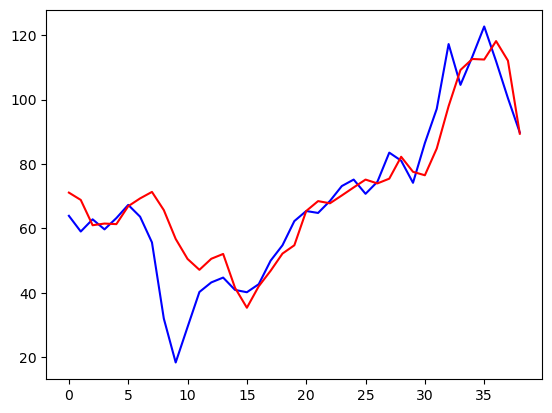

In [ ]:
plt.plot(y_test, 'b')
plt.plot(lstm_prediction, 'r')
plt.show()

Epoch 1/300: train_loss=38788.18065049913, test_loss=45912.52811686198
Epoch 2/300: train_loss=35627.04351128472, test_loss=37275.83762613932
Epoch 3/300: train_loss=34518.25933159722, test_loss=32725.088948567707
Epoch 4/300: train_loss=33971.35427517361, test_loss=29993.37599690755
Epoch 5/300: train_loss=33203.02951388889, test_loss=28064.784220377605
Epoch 6/300: train_loss=32871.767415364586, test_loss=26246.021494547527
Epoch 7/300: train_loss=26305.293918185766, test_loss=24356.36341349284
Epoch 8/300: train_loss=21402.83816189236, test_loss=22012.010955810547
Epoch 9/300: train_loss=18195.85571967231, test_loss=19695.943440755207
Epoch 10/300: train_loss=16384.66839260525, test_loss=17998.909790039062
Epoch 11/300: train_loss=14934.614352756076, test_loss=16408.261311848957
Epoch 12/300: train_loss=13601.140804714627, test_loss=15312.026067097982
Epoch 13/300: train_loss=12665.542419433594, test_loss=14386.088455200195
Epoch 14/300: train_loss=11735.261216905383, test_loss=1370

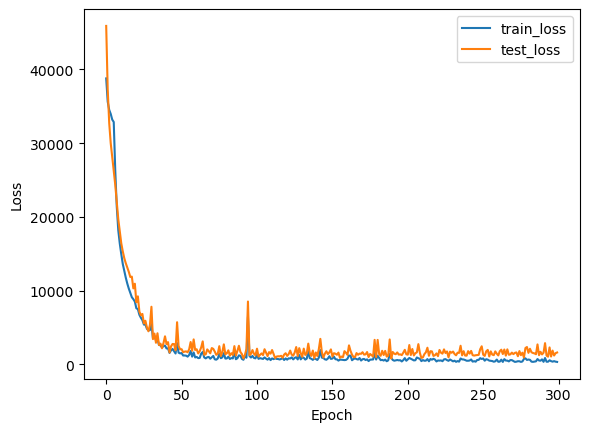

79.2500039644552
6.4574812395144745
0.13231031805887603
59.02382979459887
5.905013609585698
0.10389582447880837


In [ ]:
import torch.nn as nn

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(GRU, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out
    
gru_model = GRU(input_size=len(selected_features), hidden_size=128, num_layers=2, dropout=0.2)
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(gru_model.parameters(), lr=0.004)

train_loss_list = []
validate_loss_list = []

num_epochs = 300
min_epoch = 0
min_loss = 9999
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(my_train_dataloader):
        inputs = inputs.reshape(len(inputs), time_window, len(selected_features))
        outputs = gru_model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # calculate train loss
    with torch.no_grad():
        train_total_loss = 0
        for inputs, targets in my_train_dataloader:
            inputs = inputs.reshape(len(inputs), time_window, len(selected_features))
            outputs = gru_model(inputs)
            train_loss = criterion(outputs, targets)
            train_total_loss += train_loss.item() * len(targets)
        train_loss_list.append(train_total_loss / len(my_train_dataloader))
    
    # calculate test loss
    with torch.no_grad():
        validate_total_loss = 0
        for inputs, targets in my_validate_dataloader:
            inputs = inputs.reshape(len(inputs), time_window, len(selected_features))
            outputs = gru_model(inputs)
            validate_loss = criterion(outputs, targets)
            if validate_loss < min_loss:
                min_loss = validate_loss
                min_epoch = epoch
            validate_total_loss += validate_loss.item() * len(targets)
        validate_loss_list.append(validate_total_loss / len(my_validate_dataloader))
    
    # print train and test loss for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}: train_loss={train_loss_list[-1]}, test_loss={validate_loss_list[-1]}")


print("Min Epoch:", min_epoch)   
    
# plot train and test loss over epochs
plt.plot(train_loss_list, label='train_loss')
plt.plot(validate_loss_list, label='test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

gru_prediction = np.array([])
with torch.no_grad():
    total_loss = 0
    for inputs, targets in my_test_dataloader:
        inputs = inputs.reshape(len(inputs), time_window, len(selected_features))
        outputs = gru_model(inputs)
        gru_prediction = np.append(gru_prediction, outputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item() * len(targets)

    test_loss = total_loss / len(my_test_dataloader)

print(mean_squared_error(y_test.ravel(), gru_prediction))
print(mean_absolute_error(y_test.ravel(), gru_prediction))
print(mean_absolute_percentage_error(y_test.ravel(), gru_prediction))

gru_train_res = np.array([])
with torch.no_grad():
    for inputs, targets in my_train_dataloader:
        inputs = inputs.reshape(len(inputs), time_window, len(selected_features))
        outputs = gru_model(inputs)
        gru_train_res = np.append(gru_train_res, outputs)

gru_validate_res = np.array([])
with torch.no_grad():
    for inputs, targets in my_validate_dataloader:
        inputs = inputs.reshape(len(inputs), time_window, len(selected_features))
        outputs = gru_model(inputs)
        gru_validate_res = np.append(gru_validate_res, outputs)
        
print(mean_squared_error(y_validate.ravel(), gru_validate_res))
print(mean_absolute_error(y_validate.ravel(), gru_validate_res))
print(mean_absolute_percentage_error(y_validate.ravel(), gru_validate_res))

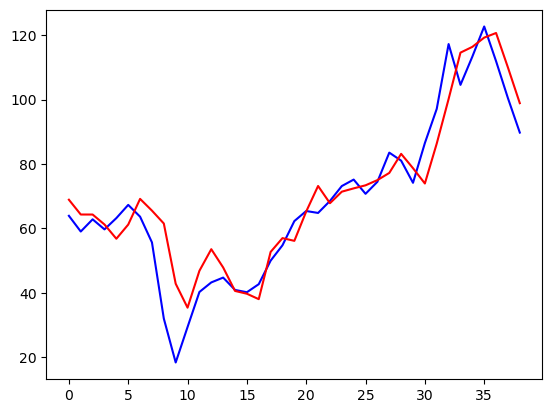

In [ ]:
plt.plot(y_test, 'b')
plt.plot(gru_prediction, 'r')
plt.show()

In [ ]:
from sklearn.svm import SVR

svr = SVR(C=1.0, epsilon=0.2)
svr.fit(X_train.reshape(len(X_train), -1), y_train)
svr_validate_res = svr.predict(X_validate.reshape(len(X_validate), -1))
svr_prediction = svr.predict(X_test.reshape(len(X_test), -1))
svr_train_res = svr.predict(X_train.reshape(len(X_train), -1))
print(mean_absolute_error(y_test, svr.predict(X_test.reshape(len(X_test), -1))))
print(mean_squared_error(y_test, svr.predict(X_test.reshape(len(X_test), -1))))
print(mean_absolute_percentage_error(y_test, svr.predict(X_test.reshape(len(X_test), -1))))

10.5917668452739
229.25404585436635
0.2030260140379927


d:\Anaconda\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


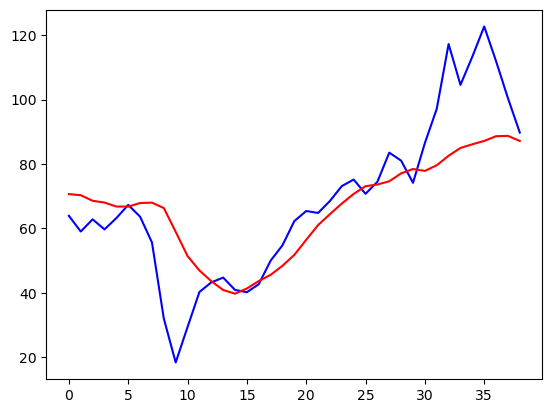

In [ ]:
plt.plot(y_test, 'b')
plt.plot(svr_prediction, 'r')
plt.show()

Epoch 1/200: train_loss=89258.88302951389, test_loss=122046.43424479167
Epoch 2/200: train_loss=79597.85875108506, test_loss=111013.72241210938
Epoch 3/200: train_loss=63533.67873467339, test_loss=90071.7079264323
Epoch 4/200: train_loss=41672.05584038628, test_loss=59464.296549479164
Epoch 5/200: train_loss=21548.089925130207, test_loss=27787.35390218099
Epoch 6/200: train_loss=9716.82086690267, test_loss=11424.254211425781
Epoch 7/200: train_loss=10619.924391004773, test_loss=15210.192186991373
Epoch 8/200: train_loss=9113.502624511719, test_loss=11991.814041137695
Epoch 9/200: train_loss=8556.600453694662, test_loss=9744.378509521484
Epoch 10/200: train_loss=8578.11366780599, test_loss=9535.591303507486
Epoch 11/200: train_loss=6893.459299723308, test_loss=8006.198959350586
Epoch 12/200: train_loss=6188.72529941135, test_loss=8038.643778483073
Epoch 13/200: train_loss=6402.039896647136, test_loss=7477.159891764323
Epoch 14/200: train_loss=5399.9034593370225, test_loss=5880.592341105

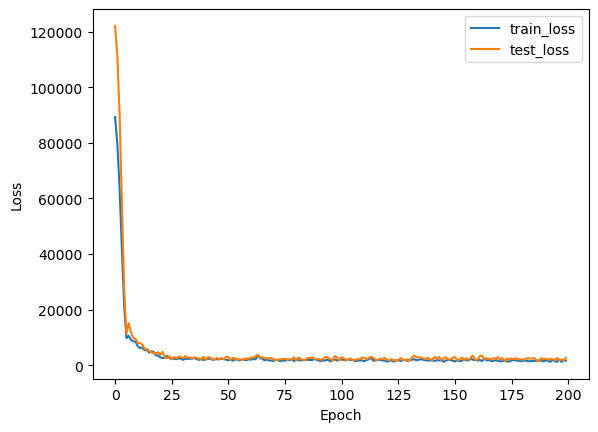

150.49642741022512
9.785589247483474
0.16068085302933222
(73,)
63.485550840503265
6.322800574106713
0.09839974300768356


In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        out = self.fc1(x)
        out = nn.functional.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = nn.functional.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out

mlp_model = MLP(input_size=len(selected_features) * time_window, hidden_size=72, output_size=1, dropout=0.2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.007)

num_epochs = 100
train_loss_list = []
validate_loss_list = []

for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(my_train_dataloader):
        inputs = inputs.view(len(inputs), -1)
        outputs = mlp_model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # calculate train loss
    with torch.no_grad():
        train_total_loss = 0
        for inputs, targets in my_train_dataloader:
            inputs = inputs.view(len(inputs), -1)
            outputs = mlp_model(inputs)
            train_loss = criterion(outputs, targets)
            train_total_loss += train_loss.item() * len(targets)
        train_loss_list.append(train_total_loss / len(my_train_dataloader))
    
    # calculate test loss
    with torch.no_grad():
        validate_total_loss = 0
        for inputs, targets in my_validate_dataloader:
            inputs = inputs.view(len(inputs), -1)
            outputs = mlp_model(inputs)
            validate_loss = criterion(outputs, targets)
            validate_total_loss += validate_loss.item() * len(targets)
        validate_loss_list.append(validate_total_loss / len(my_validate_dataloader))
    
    # print train and test loss for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}: train_loss={train_loss_list[-1]}, test_loss={validate_loss_list[-1]}")

# plot train and test loss over epochs
plt.plot(train_loss_list, label='train_loss')
plt.plot(validate_loss_list, label='test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

mlp_prediction = np.array([])
with torch.no_grad():
    total_loss = 0
    for inputs, targets in my_test_dataloader:
        inputs = inputs.view(len(inputs), -1)
        outputs = mlp_model(inputs)
        mlp_prediction = np.append(mlp_prediction, outputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item() * len(targets)

    test_loss = total_loss / len(my_test_dataloader)

mlp_train_res = np.array([])
with torch.no_grad():
    for inputs, targets in my_train_dataloader:
        inputs = inputs.reshape(len(inputs), -1)
        outputs = mlp_model(inputs)
        mlp_train_res = np.append(mlp_train_res, outputs)

print(mean_squared_error(y_test.ravel(), mlp_prediction))
print(mean_absolute_error(y_test.ravel(), mlp_prediction))
print(mean_absolute_percentage_error(y_test.ravel(), mlp_prediction))

mlp_validate_res = np.array([])
with torch.no_grad():
    for inputs, targets in my_validate_dataloader:
        inputs = inputs.reshape(len(inputs), -1)
        outputs = mlp_model(inputs)
        mlp_validate_res = np.append(mlp_validate_res, outputs)
print(mlp_validate_res.shape)
print(mean_squared_error(y_validate.ravel(), mlp_validate_res))
print(mean_absolute_error(y_validate.ravel(), mlp_validate_res))
print(mean_absolute_percentage_error(y_validate.ravel(), mlp_validate_res))

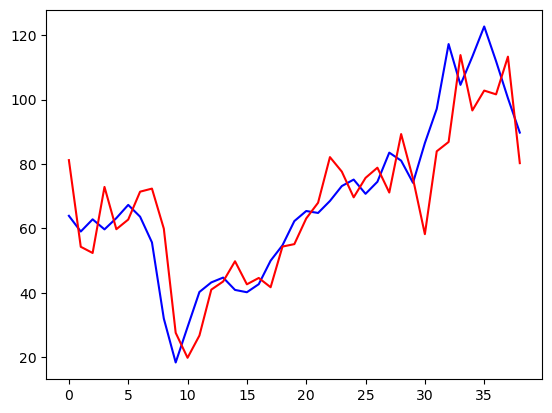

In [ ]:
plt.plot(y_test, 'b')
plt.plot(mlp_prediction, 'r')
plt.show()

In [ ]:
# from TCN.tcn import TemporalConvNet

# class TCN(nn.Module):
#     def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
#         super(TCN, self).__init__()
#         self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
#         self.linear = nn.Linear(num_channels[-1] * time_window, output_size)

#     def forward(self, x):
#         # x.shape: (batch_size, input_size, sequence_length)
#         y = self.tcn(x)  # y.shape: (batch_size, num_channels[-1], sequence_length)
# #         y = y[:, :, -1]  # y.shape: (batch_size, num_channels[-1])
#         y = y.reshape(len(y), -1)
#         y = self.linear(y)  # y.shape: (batch_size, output_size)
#         return y

#     def predict(self, x):
#         res = np.zeros((len(x),))
#         for i in range(len(x)):
#             inputs = torch.from_numpy(x[i].reshape(1, selected_features_num, 6)).to(device).float()
#             res[i] = self.forward(inputs)
#         return res
    
# tcn_model = TCN(input_size=len(selected_features), output_size=1, num_channels=[32, 64, 128], kernel_size=2, dropout=0.2)

# loss = nn.MSELoss()
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(tcn_model.parameters(), lr=0.001, weight_decay=0.01)

# num_epochs = 128

# train_loss_list = []
# validate_loss_list = []

# for epoch in range(num_epochs):
#     for i, (inputs, targets) in enumerate(my_train_dataloader):
#         inputs = inputs.view(len(inputs), len(selected_features), time_window)
#         outputs = tcn_model(inputs)
#         loss = criterion(outputs, targets)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     # calculate train loss
#     with torch.no_grad():
#         train_total_loss = 0
#         for inputs, targets in my_train_dataloader:
#             inputs = inputs.view(len(inputs), len(selected_features), time_window)
#             outputs = tcn_model(inputs)
#             train_loss = criterion(outputs, targets)
#             train_total_loss += train_loss.item() * len(targets)
#         train_loss_list.append(train_total_loss / len(my_train_dataloader))
    
#     # calculate test loss
#     with torch.no_grad():
#         validate_total_loss = 0
#         for inputs, targets in my_validate_dataloader:
#             inputs = inputs.view(len(inputs), len(selected_features), time_window)
#             outputs = tcn_model(inputs)
#             validate_loss = criterion(outputs, targets)
#             validate_total_loss += validate_loss.item() * len(targets)
#         validate_loss_list.append(validate_total_loss / len(my_validate_dataloader))
    
#     # print train and test loss for each epoch
#     print(f"Epoch {epoch+1}/{num_epochs}: train_loss={train_loss_list[-1]}, test_loss={validate_loss_list[-1]}")

# # plot train and test loss over epochs
# plt.plot(train_loss_list, label='train_loss')
# plt.plot(validate_loss_list, label='test_loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# tcn_train_res = np.array([])
# with torch.no_grad():
#     for inputs, targets in my_train_dataloader:
#         inputs = inputs.view(len(inputs), len(selected_features), time_window)
#         outputs = tcn_model(inputs)
#         tcn_train_res = np.append(tcn_train_res, outputs)

# tcn_prediction = np.array([])
# with torch.no_grad():
#     total_loss = 0
#     for inputs, targets in my_test_dataloader:
#         inputs = inputs.view(len(inputs), len(selected_features), time_window)
#         outputs = tcn_model(inputs)
#         tcn_prediction = np.append(tcn_prediction, outputs)
#         total_loss += loss.item() * len(targets)

# print(mean_squared_error(y_test.ravel(), tcn_prediction))
# print(mean_absolute_error(y_test.ravel(), tcn_prediction))
# print(mean_absolute_percentage_error(y_test.ravel(), tcn_prediction))

# tcn_validate_res = np.array([])
# with torch.no_grad():
#     for inputs, targets in my_validate_dataloader:
#         inputs = inputs.reshape(len(inputs), len(selected_features), time_window)
#         outputs = tcn_model(inputs)
#         tcn_validate_res = np.append(tcn_validate_res, outputs)
# print(tcn_validate_res.shape)
# print(mean_squared_error(y_validate.ravel(), tcn_validate_res))
# print(mean_absolute_error(y_validate.ravel(), tcn_validate_res))
# print(mean_absolute_percentage_error(y_validate.ravel(), tcn_validate_res))

In [ ]:
model = [svr, mlp_model, gru_model, lstm_model]
model_name = ["SVR", "MLP", "GRU", "LSTM"]

model_validate_res = [svr_validate_res, mlp_validate_res, gru_validate_res, lstm_validate_res]
print(len(model))

4


In [ ]:
# import random
# from deap import base, creator, tools

# POPULATION_SIZE = 300
# NUM_GENERATIONS = 25
# CROSSOVER_PROB = 0.8
# MUTATION_PROB = 0.1
# ELITISM_SIZE = 100
# num_models = len(model)

# def getInitPop():
#     models_predictions = np.zeros((len(lstm_validate_res), num_models))
#     for i in range(len(model)):
#         models_predictions[:, i] = model_validate_res[i].reshape(-1)
#     print(models_predictions.shape)
#     return models_predictions

# models_predictions = getInitPop()

# def evaluate(individual):
#     res = models_predictions.copy()
#     for i in range(len(model)):
#         res[:, i] *= individual[i]
#     res = np.sum(res, axis=1)
#     mse = mean_squared_error(res, y_validate)
#     return mse,


# creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
# creator.create("Individual", list, fitness=creator.FitnessMin)

# toolbox = base.Toolbox()
# toolbox.register("attr_float", random.uniform, 0, 1)
# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=num_models)
# toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# toolbox.register("evaluate", evaluate)
# toolbox.register("mate", tools.cxSimulatedBinaryBounded, eta=20.0)
# toolbox.register("mutate", tools.mutPolynomialBounded, eta=20.0, low=0, up=1.0, indpb=1.0 / num_models)
# toolbox.register("select", tools.selNSGA2)

# best_individuals = []
# def GA():
#     pop = toolbox.population(n=POPULATION_SIZE)

#     for gen in range(NUM_GENERATIONS):
#         fitnesses = toolbox.map(toolbox.evaluate, pop)
#         for ind, fit in zip(pop, fitnesses):
#             ind.fitness.values = fit

#         offspring = toolbox.select(pop, len(pop))

#         offspring = [toolbox.clone(ind) for ind in offspring]
#         for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
#             if random.random() < CROSSOVER_PROB:
#                 toolbox.mate(ind1, ind2, low=0, up=1)
#             toolbox.mutate(ind1)
#             toolbox.mutate(ind2)
#             del ind1.fitness.values, ind2.fitness.values

#         invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
#         fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
#         for ind, fit in zip(invalid_ind, fitnesses):
#             ind.fitness.values = fit

#         pop = toolbox.select(pop + offspring, POPULATION_SIZE)

#         fits = [ind.fitness.values for ind in pop]

#         print("-- Generation %i --" % gen)
#         print("  Min MSE: %s" % min(fits, key=lambda x: x[0])[0])
#         print("  Max MSE: %s" % max(fits, key=lambda x: x[0])[0])
#         print("  Avg MSE: %s" % (sum([f[0] for f in fits]) / len(fits)))

#     global best_individuals
#     best_individuals = toolbox.select(pop, 1)
#     print("Best Individuals:")
#     for bi in best_individuals:
#         print("  %s" % str(bi))
        
# GA()

# print(best_individuals)

In [ ]:

import matlab
import matlab.engine
import scipy.io as scio
# print(y_validate.shape)
tmp = np.zeros((len(y_validate), len(model)))
for i in range(len(model)):
    tmp[:, i] = model_validate_res[i]
scio.savemat('model_validate_res.mat', {'model_validate_res':tmp})
scio.savemat('y_validate.mat', {'y_validate':np.array(y_validate)})

eng = matlab.engine.start_matlab()
it_times = 0
best_individuals = np.zeros((10, 4))
while (it_times < 10):
    print(it_times)
    try:
        eng.run("./MODA/MODA.m", nargout=0)
        
        best_individuals[it_times] =  np.array(scio.loadmat("best_individuals.mat")['data']).reshape(4,)
        it_times += 1
    except Exception as r:
        print(it_times)
        

best_individuals = np.mean(best_individuals, axis=0)

print(best_individuals)

0
0
0
1
2


In [ ]:
best_individuals = np.array(best_individuals).reshape(4,)

In [ ]:
merge_model_prediction = []
# merge_model_prediction.append(svr_prediction)
merge_model_prediction.append(svr_prediction)
merge_model_prediction.append(mlp_prediction)
merge_model_prediction.append(gru_prediction)
merge_model_prediction.append(lstm_prediction)
merge_res = np.zeros((len(mlp_prediction), 1))
best_individuals = np.array(best_individuals).reshape(-1)
ave_res = np.zeros_like(merge_res)
merge_model_prediction_cp = merge_model_prediction.copy()

import os
if not os.path.exists("test_data.xlsx"):
    test_data = pd.DataFrame([], columns=['MyModel', 'Mean', *model_name, "IS_ALL_BETTER"])
else:
    test_data = pd.read_excel("test_data.xlsx")

tmp_data = pd.Series(index=test_data.columns)

for i in range(len(merge_model_prediction)):
    merge_res += (merge_model_prediction[i] * best_individuals[i]).reshape(len(lstm_prediction), 1)

print("MyModel")
tmp_data['MyModel'] = {"MSE":mean_squared_error(merge_res, y_test),
                                "MAE":mean_absolute_error(merge_res, y_test),
                                "MAPE":mean_absolute_percentage_error(merge_res, y_test)}

print(mean_squared_error(merge_res, y_test))
print(mean_absolute_error(merge_res, y_test))
print(mean_absolute_percentage_error(merge_res, y_test))

for i in range(len(merge_model_prediction_cp)):
    ave_res += (merge_model_prediction_cp[i] * (1 / (len(model)))).reshape(len(mlp_prediction), 1)

print("Mean")
tmp_data['Mean'] = {"MSE":mean_squared_error(ave_res, y_test),
                                "MAE":mean_absolute_error(ave_res, y_test),
                                "MAPE":mean_absolute_percentage_error(ave_res, y_test)}
print(mean_squared_error(ave_res, y_test))
print(mean_absolute_error(ave_res, y_test))
print(mean_absolute_percentage_error(ave_res, y_test))

for i in range(len(merge_model_prediction)):
    print(model_name[i])
    tmp_data[model_name[i]] = {"MSE":mean_squared_error(merge_model_prediction[i], y_test),
                                "MAE":mean_absolute_error(merge_model_prediction[i], y_test),
                                "MAPE":mean_absolute_percentage_error(merge_model_prediction[i], y_test)}
    print(mean_squared_error(merge_model_prediction[i], y_test))
    print(mean_absolute_error(merge_model_prediction[i], y_test))
    print(mean_absolute_percentage_error(merge_model_prediction[i], y_test))

print(best_individuals)
# "IS_ALL_BETTER"

if tmp_data["MyModel"]['MSE'] < tmp_data["Mean"]['MSE'] \
    and tmp_data["MyModel"]['MAPE'] < tmp_data["Mean"]['MAPE']:
    tmp_data["IS_ALL_BETTER"] = True
else:
    tmp_data["IS_ALL_BETTER"] = False

test_data = test_data._append(tmp_data, ignore_index=True)
test_data.to_excel("test_data.xlsx", index=False)

MyModel
20.356342220006333
3.41334799232815
0.0686968929586507
Mean
21.994176184172254
3.36531828003258
0.06474525480922294
ARIMAX
56.00719921516564
4.6770639624481305
0.08226304618627656
MLP
40.1388439831322
4.523493276596069
0.09147826182312849
GRU
33.23291995597623
4.176244029045105
0.07729398168030292
LSTM
27.981781226127055
3.806505640029907
0.0764235506992919
[0.         0.10210693 0.54953224 0.33194277]


PermissionError: [Errno 13] Permission denied: 'test_data.xlsx'

In [ ]:
for i in range(len(model_validate_res)):
    print(model_name[i])
    print(mean_squared_error(model_validate_res[i], y_validate))
    print(mean_absolute_error(model_validate_res[i], y_validate))
    print(mean_absolute_percentage_error(model_validate_res[i], y_validate))

ARIMAX
45.87624938855832
4.696032073427824
0.11205067589087263
MLP
54.77922117294321
4.7805376161847795
0.1008265401339079
GRU
22.62458362366493
3.5695445043390452
0.10883486822702587
LSTM
26.46326169672248
3.4493372617449074
0.08437834630667977


In [ ]:
test_data

,MyModel,Mean,ARIMAX,MLP,GRU,LSTM,IS_ALL_BETTER
0,"{'MSE': 17.542659145745017, 'MAE': 3.108848556...","{'MSE': 23.590718893442553, 'MAE': 3.594575169...","{'MSE': 56.00719921516564, 'MAE': 4.6770639624...","{'MSE': 56.50369014543103, 'MAE': 5.7072841253...","{'MSE': 21.55446375413988, 'MAE': 3.5042685756...","{'MSE': 29.18528907500946, 'MAE': 3.8846208124...",True
1,"{'MSE': 20.488501183497824, 'MAE': 3.437651399...","{'MSE': 32.07775100172963, 'MAE': 4.0218971548...","{'MSE': 56.00719921516564, 'MAE': 4.6770639624...","{'MSE': 45.84736910597648, 'MAE': 5.0716178226...","{'MSE': 35.11108469390287, 'MAE': 4.4110375356...","{'MSE': 28.500349465902666, 'MAE': 3.677014961...",True
2,"{'MSE': 28.941786961642187, 'MAE': 3.773539009...","{'MSE': 33.93902025877148, 'MAE': 4.1399534708...","{'MSE': 56.00719921516564, 'MAE': 4.6770639624...","{'MSE': 89.81862295497305, 'MAE': 6.0693951940...","{'MSE': 34.54836617413123, 'MAE': 4.1764783697...","{'MSE': 29.01201266584738, 'MAE': 4.0543945169...",True
3,"{'MSE': 22.332697899669682, 'MAE': 3.365397198...","{'MSE': 29.065977445154545, 'MAE': 3.860254411...","{'MSE': 56.00719921516564, 'MAE': 4.6770639624...","{'MSE': 54.17662845962011, 'MAE': 5.4112084712...","{'MSE': 30.658792898423123, 'MAE': 4.115827838...","{'MSE': 42.48808470503873, 'MAE': 4.5475180473...",True
4,"{'MSE': 21.240167150977317, 'MAE': 3.185804044...","{'MSE': 25.28666117416315, 'MAE': 3.4964875267...","{'MSE': 56.00719921516564, 'MAE': 4.6770639624...","{'MSE': 30.885563933806726, 'MAE': 4.153288514...","{'MSE': 35.33544726032335, 'MAE': 4.1391416978...","{'MSE': 39.24389804943401, 'MAE': 4.4437550392...",True
5,"{'MSE': 22.16866324469571, 'MAE': 3.4496967057...","{'MSE': 31.561037839141857, 'MAE': 3.880458346...","{'MSE': 56.00719921516564, 'MAE': 4.6770639624...","{'MSE': 41.38902206740848, 'MAE': 4.6576684579...","{'MSE': 43.82102645451048, 'MAE': 4.7202509727...","{'MSE': 43.510889275568225, 'MAE': 4.890905096...",True
6,"{'MSE': 21.082707263532757, 'MAE': 3.434858977...","{'MSE': 35.00341154393352, 'MAE': 4.2876106697...","{'MSE': 56.00719921516564, 'MAE': 4.6770639624...","{'MSE': 87.64791508939469, 'MAE': 7.2597067289...","{'MSE': 34.0201049851226, 'MAE': 4.17549209976...","{'MSE': 29.635948378979116, 'MAE': 4.129142826...",True
7,"{'MSE': 20.760202108265197, 'MAE': 3.342722897...","{'MSE': 24.93230232927575, 'MAE': 3.7419984413...","{'MSE': 56.00719921516564, 'MAE': 4.6770639624...","{'MSE': 36.149183353253235, 'MAE': 5.041433576...","{'MSE': 30.060847837487067, 'MAE': 3.938347493...","{'MSE': 22.200908489672248, 'MAE': 3.658868612...",True
8,"{'MSE': 20.382570521162954, 'MAE': 3.304843124...","{'MSE': 37.67987767076467, 'MAE': 4.2551866784...","{'MSE': 56.00719921516564, 'MAE': 4.6770639624...","{'MSE': 90.2915007570036, 'MAE': 6.25935028076...","{'MSE': 52.2962577433784, 'MAE': 5.20278542709...","{'MSE': 32.10003685239887, 'MAE': 4.2243076343...",True
9,"{'MSE': 15.26764364622952, 'MAE': 3.0901326726...","{'MSE': 28.662928136203742, 'MAE': 3.759405113...","{'MSE': 56.00719921516564, 'MAE': 4.6770639624...","{'MSE': 50.68939365269131, 'MAE': 5.0513066940...","{'MSE': 32.4773914737637, 'MAE': 4.17588658618...","{'MSE': 25.515695935372957, 'MAE': 3.885710590...",True
